## Import libraries 📚

In [5]:
import numpy as np
from tqdm.notebook import tqdm

In [6]:
# run it twice if it doesn't work
from tsai.all import *
computer_setup()

os             : Linux-5.11.0-37-generic-x86_64-with-glibc2.29
python         : 3.8.10
tsai           : 0.2.22
fastai         : 2.5.2
fastcore       : 1.3.26
torch          : 1.9.1+cu102
n_cpus         : 8
device         : cpu


## How to use the original ROCKET method? 🚀

ROCKET is applied in 2 phases:

1. Generate features from each time series: ROCKET calculates 20k features from each time series, independently of the sequence length. 
2. Apply a classifier to those calculated features. Those features are then used by the classifier of your choice. In the original code they use 2 simple linear classifiers: RidgeClassifierCV and Logistic Regression, but you can use any classifier.

### 1️⃣ Generate features

Let's first generate the features. We'll import data from a UCR Time Series dataset.

The original method requires the time series to be in a 2d array of shape (samples, len). Remember than only univariate sequences are allow in this original method.

In [68]:
time = 256
data_p1 = np.load("../../Pre-Processing/trials/subject_1_session_1_raw.npy")
labels_p1 = np.array([0,1,2, 3]*5)

data_p2 = np.load("../../Pre-Processing/trials/subject_1_session_2_raw.npy")
labels_p2 = np.array([0,1,2, 3]*5)

data_p1 = np.concatenate((data_p1, data_p2), axis = 0)
labels_p1 = np.array([0,1,2,3]*10)

data_p1 = data_p1[:,:,:time]

## How to use ROCKET with large and/ or multivariate datasets on GPU? - Recommended ⭐️

As stated before, the current ROCKET method doesn't support multivariate time series or GPU. This may be a drawback in some cases. 

To overcome both limitations I've created a multivariate ROCKET on GPU in Pytorch. 

### 1️⃣ Generate features

First you prepare the input data and normalize it per sample. The input to ROCKET Pytorch is a 3d tensor of shape (samples, vars, len), preferrable on gpu.

The way to use ROCKET in Pytorch is the following:

* Create a dataset as you would normally do in `tsai`. 
* Create a TSDataLoaders with the following kwargs: 
    * drop_last=False. In this way we get features for every input sample.
    * shuffle_train=False
    * batch_tfms=[TSStandardize(by_sample=True)] so that input is normalized by sample, as recommended by the authors


In [69]:
#X, y, splits = get_UCR_data('HandMovementDirection', split_data=False)
#splits = RandomSplitter()(range_of(data_p1))

data_p1 = np.load("../../Pre-Processing/trials/subject_1_session_1_filt_ica_car.npy")
#labels_p1 = np.array([0,1,2, 3]*5)

data_p2 = np.load("../../Pre-Processing/trials/subject_1_session_2_filt_ica_car.npy")
#labels_p2 = np.array([0,1,2, 3]*5)

splits_1 = TrainValidTestSplitter(stratify = True, random_state= 10, valid_size = 0.)(range_of(data_p1))
splits_2 = TrainValidTestSplitter(stratify = True, random_state= 0, valid_size = 0.)(range_of(data_p2))

splits = (splits_1[0], splits_2[0])
for i in range(0,20):
    splits[1][i] += 20

In [70]:
#data_p1 = np.load("../Pre-Processing/trials/subject_1_session_1_filt_ica_car.npy")
labels_p1 = np.array([0,1,2, 3]*5)

#data_p2 = np.load("../Pre-Processing/trials/subject_1_session_2_filt_ica_car.npy")
labels_p2 = np.array([0,1,2, 3]*5)

data_p1 = np.concatenate((data_p1, data_p2), axis = 0)
labels_p1 = np.array([0,1,2,3]*10)

data_p1 = data_p1[:,:,:time]

In [71]:
tfms  = [None, [Categorize()]]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(data_p1, labels_p1,splits = splits, tfms=tfms, drop_last=False, 
                 shuffle_train=True, batch_tfms=batch_tfms, bs=10_000)

☣️☣️ You will be able to create a dls (TSDataLoaders) object with unusually large batch sizes. I've tested it with a large dataset and a batch size = 100_000 and it worked fine. This is because ROCKET is not a usual Deep Learning model. It just applies convolutions (kernels) one at a time to create the features.

Instantiate a rocket model with the desired n_kernels (authors use 10_000) and kernel sizes (7, 9 and 11 in the original paper). 

In [72]:
model = build_ts_model(ROCKET, dls=dls, n_kernels = 2000, kss = [7, 9, 11]) # n_kernels=10_000, kss=[7, 9, 11] set by default, but you can pass other values as kwargs

Now generate rocket features for the entire train and valid datasets using the create_rocket_features convenience function `create_rocket_features`.

And we now transform the original data, creating 20k features per sample

In [73]:
X_train, y_train = create_rocket_features(dls.train, model)
X_valid, y_valid = create_rocket_features(dls.valid, model)
X_train.shape, X_valid.shape

((20, 4000), (20, 4000))

### 2️⃣ Apply a classifier

Once you build the 20k features per sample, you can use them to train any classifier of your choice.

#### RidgeClassifierCV

And now you apply a classifier of your choice. 
With RidgeClassifierCV in particular, there's no need to normalize the calculated features before passing them to the classifier, as it does it internally (if normalize is set to True as recommended by the authors).

In [74]:
from sklearn.linear_model import RidgeClassifierCV
ridge = RidgeClassifierCV(alphas=np.logspace(-8, 8, 17), normalize=True)
ridge.fit(X_train, y_train)
print(f'alpha: {ridge.alpha_:.2E}  train: {ridge.score(X_train, y_train):.5f}  valid: {ridge.score(X_valid, y_valid):.5f}')

alpha: 1.00E+03  train: 1.00000  valid: 1.00000


In [75]:
ridge.get_params()

{'alphas': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
        1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
        1.e+08]),
 'class_weight': None,
 'cv': None,
 'fit_intercept': True,
 'normalize': True,
 'scoring': None,
 'store_cv_values': False}

In [76]:
res = ridge.predict(X_valid)

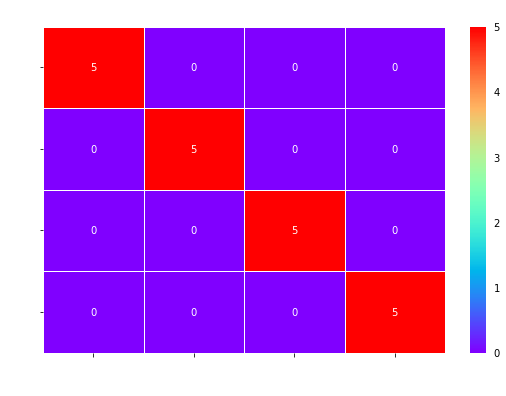

In [85]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = ['15 Hz','12 Hz','10 Hz','9 Hz']

f, ax = plt.subplots(figsize=(9, 6))
g = sns.heatmap(confusion_matrix(y_valid, res), annot=True, fmt="d", linewidths=.5, ax=ax, cmap = 'rainbow', xticklabels=labels, yticklabels=labels)
for tick_label in g.axes.get_yticklabels():
    tick_label.set_color("white")
    #tick_label.set_fontsize("30")
for tick_label in g.axes.get_xticklabels():
    tick_label.set_color("white")
    #tick_label.set_fontsize("30")
    
cax = plt.gcf().axes[-1]
cax.tick_params(color='white')
    
plt.xlabel('True label', size = 15, color = 'white')
plt.ylabel('Predicted label', size = 15, color = 'white')
plt.title('Confusion Matrix - Subject 1', size = 18, color = 'white')
plt.savefig('conf_matrix_patient_1.png', size = (100,100))

## Averaging over 50 seeds and on time range 

In [4]:
time_range = [i*8 for i in range(1, (256*3)//8 )]
valid_avg_scores = []
valid_std_scores = []

for time in tqdm(time_range):

    n_kernels = 2000
    valid_scores = []

    for i in tqdm(range(0, 50)):

        data_p1 = np.load("../../Pre-Processing/trials/subject_1_session_1_filt_ica_car.npy")
        #labels_p1 = np.array([0,1,2, 3]*5)

        data_p2 = np.load("../../Pre-Processing/trials/subject_1_session_2_filt_ica_car.npy")
        #labels_p2 = np.array([0,1,2, 3]*5)

        splits_1 = TrainValidTestSplitter(stratify = True, random_state= 1000 - i, valid_size = 0.)(range_of(data_p1))
        splits_2 = TrainValidTestSplitter(stratify = True, random_state= 0 + i, valid_size = 0.)(range_of(data_p2))

        splits = (splits_1[0], splits_2[0])
        for i in range(0,20):
            splits[1][i] += 20

        #data_p1 = np.load("../Pre-Processing/trials/subject_1_session_1_filt_ica_car.npy")
        #labels_p1 = np.array([0,1,2, 3]*5)

        #data_p2 = np.load("../Pre-Processing/trials/subject_1_session_2_filt_ica_car.npy")
        #labels_p2 = np.array([0,1,2, 3]*5)

        data_p1 = np.concatenate((data_p1, data_p2), axis = 0)
        labels_p1 = np.array([0,1,2,3]*10)

        data_p1 = data_p1[:,:,:time]

        tfms  = [None, [Categorize()]]
        batch_tfms = [TSStandardize(by_sample=True)]
        dls = get_ts_dls(data_p1, labels_p1,splits = splits, tfms=tfms, drop_last=False, 
                         shuffle_train=True, batch_tfms=batch_tfms, bs=10_000)

        model = build_ts_model(ROCKET, dls=dls, n_kernels = n_kernels, kss = [7, 9, 11]) 
        # n_kernels=10_000, kss=[7, 9, 11] set by default, but you can pass other values as kwargs

        X_train, y_train = create_rocket_features(dls.train, model)
        X_valid, y_valid = create_rocket_features(dls.valid, model)

        ridge = RidgeClassifierCV(alphas=np.logspace(-8, 8, 17), normalize=True)
        ridge.fit(X_train, y_train)
        valid_scores.append(ridge.score(X_valid, y_valid))
    
    valid_avg_scores.append(sum(valid_scores)/len(valid_scores))
    valid_std_scores.append(np.std(valid_scores))

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
#print(sum(valid_scores)/len(valid_scores), np.std(valid_scores))

In [5]:
valid_avg_scores = np.asarray(valid_avg_scores)
np.save("subj1_avg_scores.npy", valid_avg_scores)
valid_std_scores = np.asarray(valid_std_scores)
np.save("subj1_std_scores.npy", valid_std_scores)